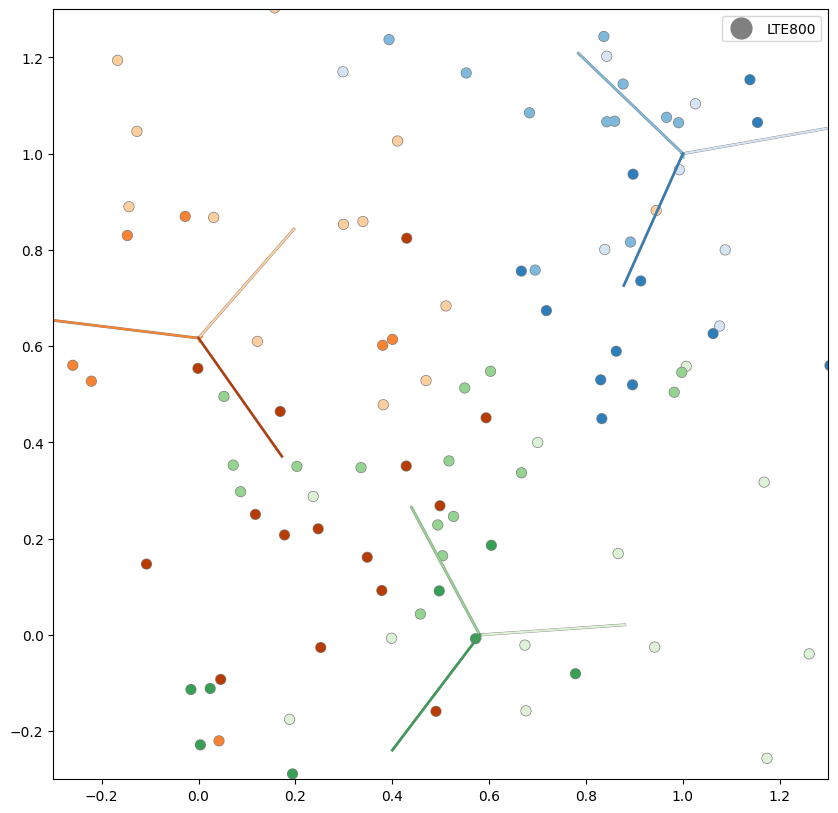

In [2]:
from datacov import TopoGen
from datacov import VoroGeom, CircleGeom, ConvexGeom, ConcaveGeom
from datacov import GenMAPL, RevHata
import numpy as np
import random

import geopandas as gpd

np.random.seed(27)

band_params = {
    'bands': [800],
    'band_probs': [1.],
    'ue_dist_scale': [0.3],
    'ue_dist_loc': [0.3]
}
topo = TopoGen(**band_params, minlim=0, maxlim=1, n_sites=3)
cells, ues = topo.generate_topo()

voro = VoroGeom.from_topo(topo)

c = CircleGeom.from_topo(topo)
circle = CircleGeom.scale_cell_shapes(c, 70)
factors = list(VoroGeom.compute_scale(c, voro))
vorocircle = CircleGeom.scale_cell_shapes(c, factors)

cvx = ConvexGeom.from_topo(topo)
ccv = ConcaveGeom.from_topo(topo)

topo.plot_topography()

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


def plot_model(coverage, topo, title, ax):

    ax.set_xlim([-1.5, 2.5])
    ax.set_ylim([-1.5, 2.5])
    handles = []
    
    # plot cell sector coverage
    if coverage is not None:
        az_color = topo.rescale_azimut(coverage.cell_shapes.azimut)
        for r, az_c in zip(coverage.cell_shapes.iterrows(), az_color):
            values = r[1]
            p = values.geometry
            bs = values.bs_id
            x, y = p.exterior.xy
            ax.fill(x, y, linestyle='dotted', color=topo.site_color[bs](az_c), alpha=0.6)
        handles.append(mpatches.Patch(color='gray', label='Cell coverage', alpha=0.6, linestyle='dotted'))
    
    # plot site boundaries
    """
    if not isinstance(coverage, EmpiricalGeom):
        for r in coverage.site_shapes.iterrows():
            values = r[1]
            p = values.geometry
            bs = values.bs_id
            x, y = p.exterior.xy
            ax.plot(x, y, color=topo.site_color[bs](0.9), alpha=0.8)
    """
    
    # plot cell azimuts
    cell_color = topo.rescale_azimut(cells.azimut)
    for r, cell_c in zip(cells.iterrows(), cell_color):
        values = r[1]
        p = values.geometry
        bs = values.bs_id
        x, y = p.xy
        ax.plot(x, y, color=topo.site_color[bs](cell_c), alpha=1, path_effects=[pe.Stroke(linewidth=3, foreground='grey'), pe.Normal()])
    handles.append(mlines.Line2D([], [], color='Gainsboro', label=f'Sector azimut', linewidth=2, path_effects=[pe.Stroke(linewidth=5, foreground='grey'), pe.Normal()]))
    
    # plot ue locations
    site_ues = ues.merge(cells[['cell_id', 'bs_id', 'azimut']], on='cell_id').sort_values(by='cell_id')
    ues_color = topo.rescale_azimut(site_ues.azimut)
    for r, ue_c in zip(site_ues.iterrows(), ues_color):
        values = r[1]
        p = values.geometry
        bs = values.bs_id
        x = [p.x for p in list(p.geoms)]
        y = [p.y for p in list(p.geoms)]
        ax.scatter(x, y, marker='o', color=topo.site_color[bs](ue_c), alpha=1, path_effects=[pe.Stroke(linewidth=2, foreground='grey'), pe.Normal()])
    handles.append(mlines.Line2D([], [], markeredgecolor='gray', markerfacecolor='Gainsboro', marker='o', markersize=8, label=f'User location', linestyle='None'))
    
    ax.legend(handles=handles, loc='lower left')
    ax.set_title(title)
    return ax
    #plt.show()


#for coverage_model, title in zip([None, voro, circle, vorocircle, cvx, ccv], titles):
#    plot_model(coverage_model, topo, title, ax)

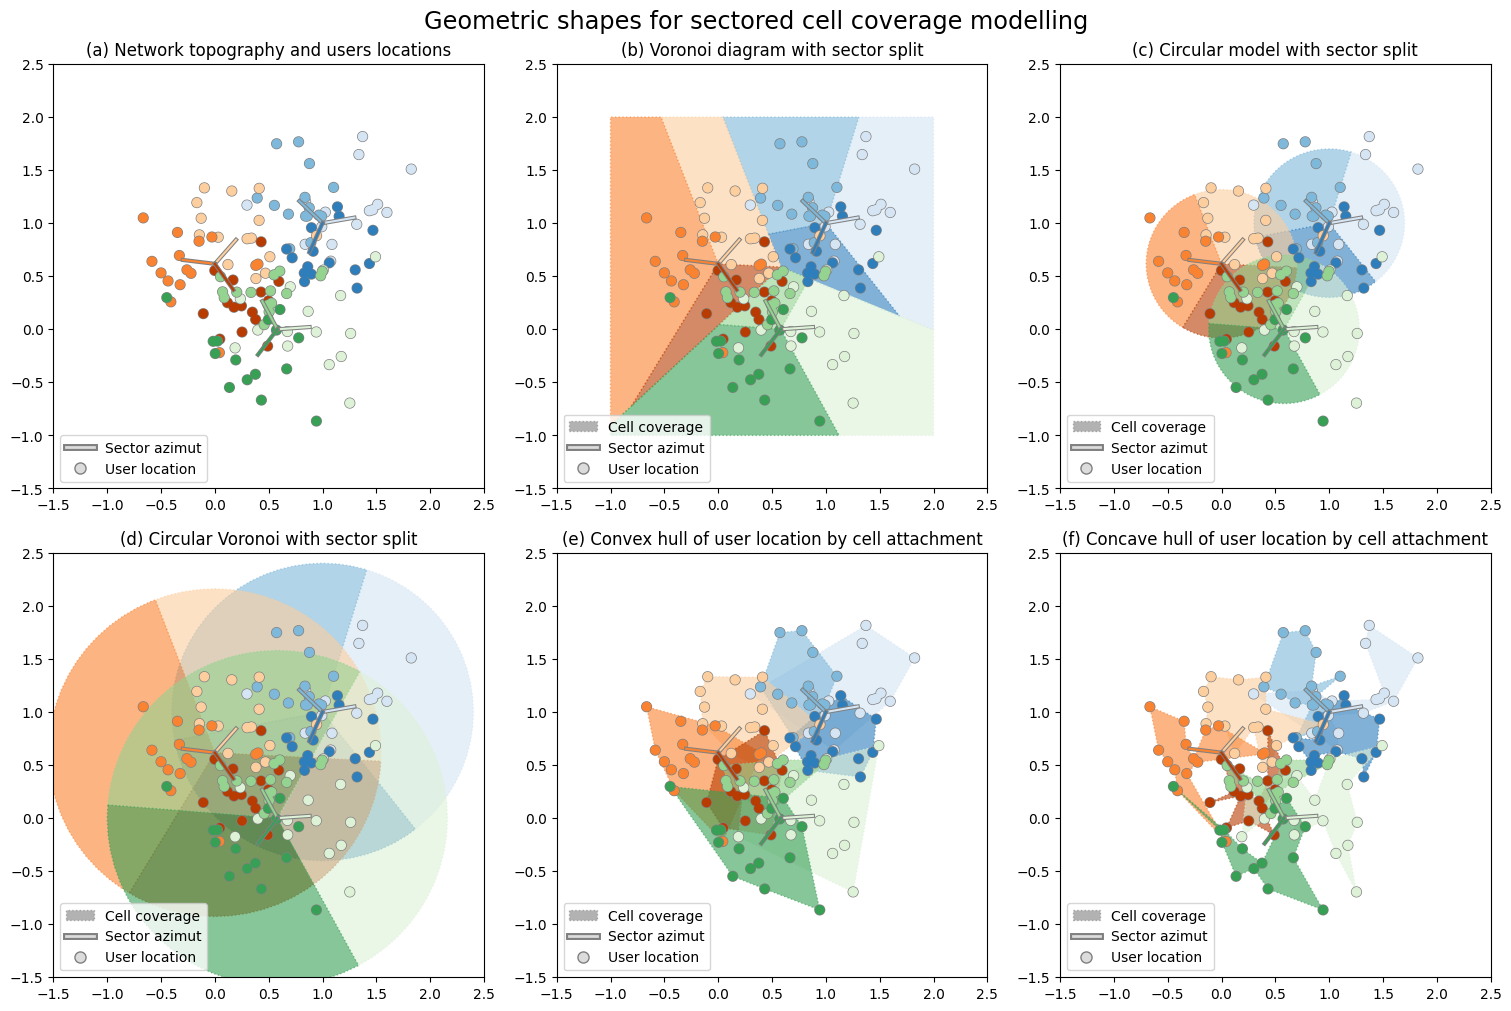

In [4]:
import matplotlib.pyplot as plt
import numpy as np

coverages = [None, voro, circle, vorocircle, cvx, ccv]

# Maximum Edge Length Ratio
titles = [
    '(a) Network topography and users locations', 
    '(b) Voronoi diagram with sector split',
    '(c) Circular model with sector split',
    '(d) Circular Voronoi with sector split',
    '(e) Convex hull of user location by cell attachment',
    '(f) Concave hull of user location by cell attachment'
]

# gridspec inside gridspec
fig = plt.figure(layout='constrained', figsize=(15, 10))
subfigs = fig.subfigures(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

for i in range(2):
    for j in range(3):
        idx = 3*i + j
        ax = subfigs[i, j].subplots(1, 1)
        pc = plot_model(coverages[idx], topo, titles[idx], ax)
#subfigs[0, 0].suptitle('Left plots', fontsize='x-large')


fig.suptitle('Geometric shapes for sectored cell coverage modelling', fontsize='xx-large')
plt.savefig('coverage_models.svg')
plt.show()


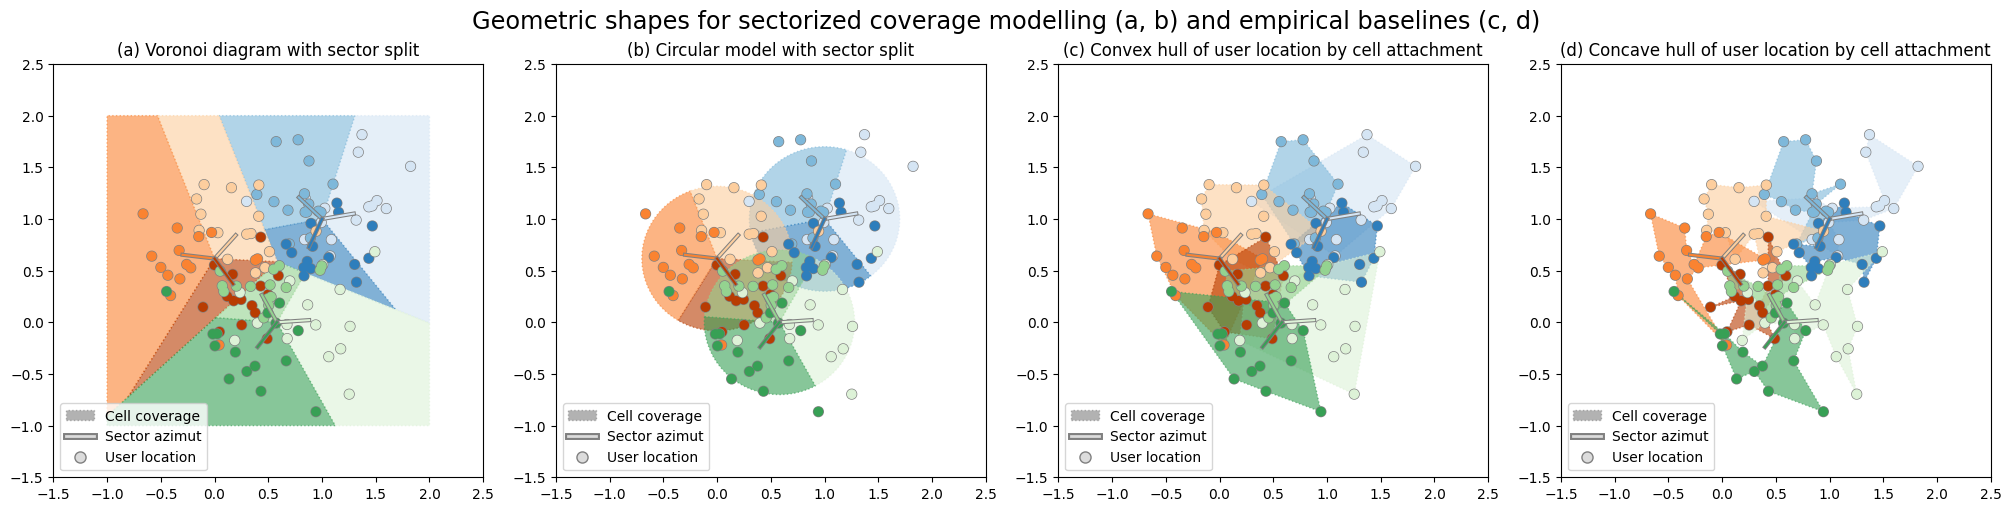

In [18]:
import matplotlib.pyplot as plt
import numpy as np

coverages = [voro, circle, cvx, ccv]

# Maximum Edge Length Ratio
titles = [
    '(a) Voronoi diagram with sector split',
    '(b) Circular model with sector split',
    '(c) Convex hull of user location by cell attachment',
    '(d) Concave hull of user location by cell attachment'
]

# gridspec inside gridspec
fig = plt.figure(layout='constrained', figsize=(20, 5))
subfigs = fig.subfigures(1, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1])

for j in range(4):
    idx = j
    ax = subfigs[j].subplots(1, 1)
    pc = plot_model(coverages[idx], topo, titles[idx], ax)
#subfigs[0, 0].suptitle('Left plots', fontsize='x-large')


fig.suptitle('Geometric shapes for sectorized coverage modelling (a, b) and empirical baselines (c, d)', fontsize='xx-large')
plt.savefig('coverage_models.pdf')
plt.show()


In [20]:
voro1 = VoroGeom.from_topo(topo)
voro_down = VoroGeom.scale_cell_shapes(voro1, 0.8)
voro_up = VoroGeom.scale_cell_shapes(voro1, 1.2)

topo.sites['height'] = [10, 50, 80]
context = ['urban']
weights = [1] 
topo_mapl = topo.cells.drop('geometry', axis=1).merge(topo.sites.drop('geometry', axis=1), on=['bs_id', 'x', 'y'])
context_array = random.choices(context, k=topo_mapl.shape[0], weights=weights)

radius_model_1 = RevHata(GenMAPL(topo_mapl, n_prb=1, context_array=context_array))
radius_model_50 = RevHata(GenMAPL(topo_mapl, n_prb=50, context_array=context_array))

circle = CircleGeom.from_topo(topo)
circle1 = CircleGeom.scale_cell_shapes(circle, radius_model=radius_model_1)
circle1_km = CircleGeom.scale_cell_shapes(circle1, sfact=0.001)
circle50 = CircleGeom.scale_cell_shapes(circle, radius_model=radius_model_50)
circle50_km = CircleGeom.scale_cell_shapes(circle50, sfact=0.001)
circle_default = CircleGeom.scale_cell_shapes(circle, sfact=10)

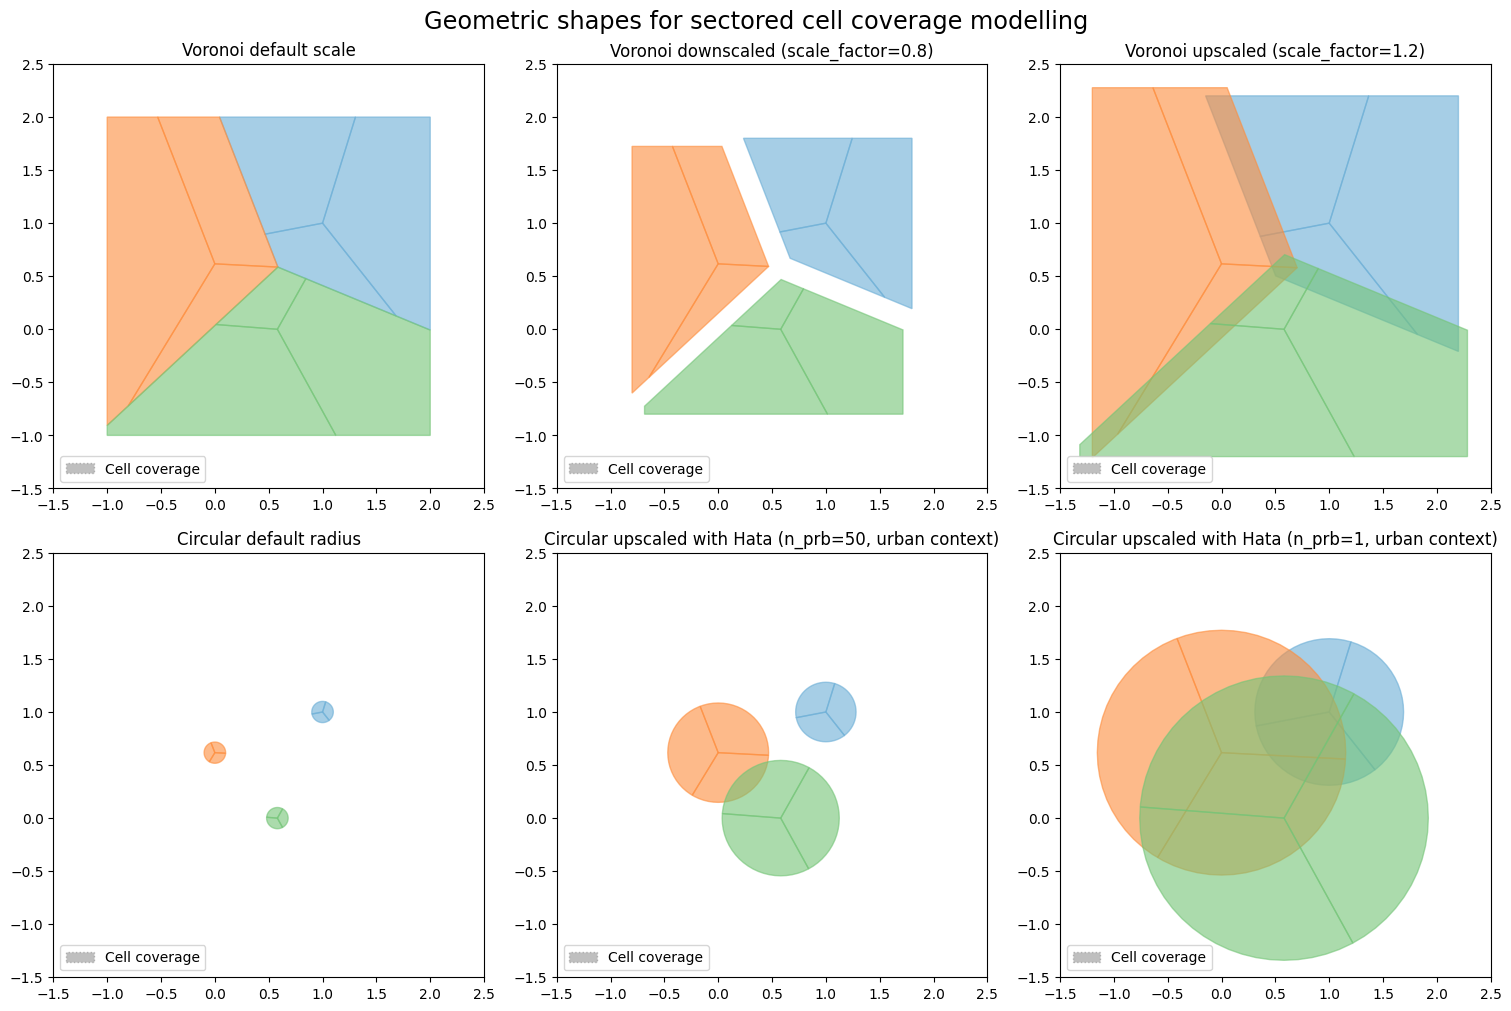

In [6]:
coverages = [voro1, voro_down, voro_up, circle_default, circle50_km, circle1_km,]
titles = [
    'Voronoi default scale',
    'Voronoi downscaled (scale_factor=0.8)',
    'Voronoi upscaled (scale_factor=1.2)',
    'Circular default radius',
    'Circular upscaled with Hata (n_prb=50, urban context)',
    'Circular upscaled with Hata (n_prb=1, urban context)',
]

def plot_scale(coverage, topo, title, ax):
    ax.set_xlim([-1.5, 2.5])
    ax.set_ylim([-1.5, 2.5])
    handles = []

    # plot cell sector coverage
    az_color = topo.rescale_azimut(coverage.cell_shapes.azimut)
    for r, az_c in zip(coverage.cell_shapes.iterrows(), az_color):
        values = r[1]
        p = values.geometry
        bs = values.bs_id
        x, y = p.exterior.xy
        ax.fill(x, y, linestyle='solid', color=topo.site_color[bs](0.5), alpha=0.6)
    handles.append(mpatches.Patch(color='gray', label='Cell coverage', alpha=0.5, linestyle='dotted'))
    ax.legend(handles=handles, loc='lower left')
    ax.set_title(title)
    return ax


# gridspec inside gridspec
fig = plt.figure(layout='constrained', figsize=(15, 10))
subfigs = fig.subfigures(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

for i in range(2):
    for j in range(3):
        idx = 3*i + j
        ax = subfigs[i, j].subplots(1, 1)
        pc = plot_scale(coverages[idx], topo, titles[idx], ax)
#subfigs[0, 0].suptitle('Left plots', fontsize='x-large')

fig.suptitle('Geometric shapes for sectored cell coverage modelling', fontsize='xx-large')
plt.savefig(f'coverage_scales.svg')
plt.show()


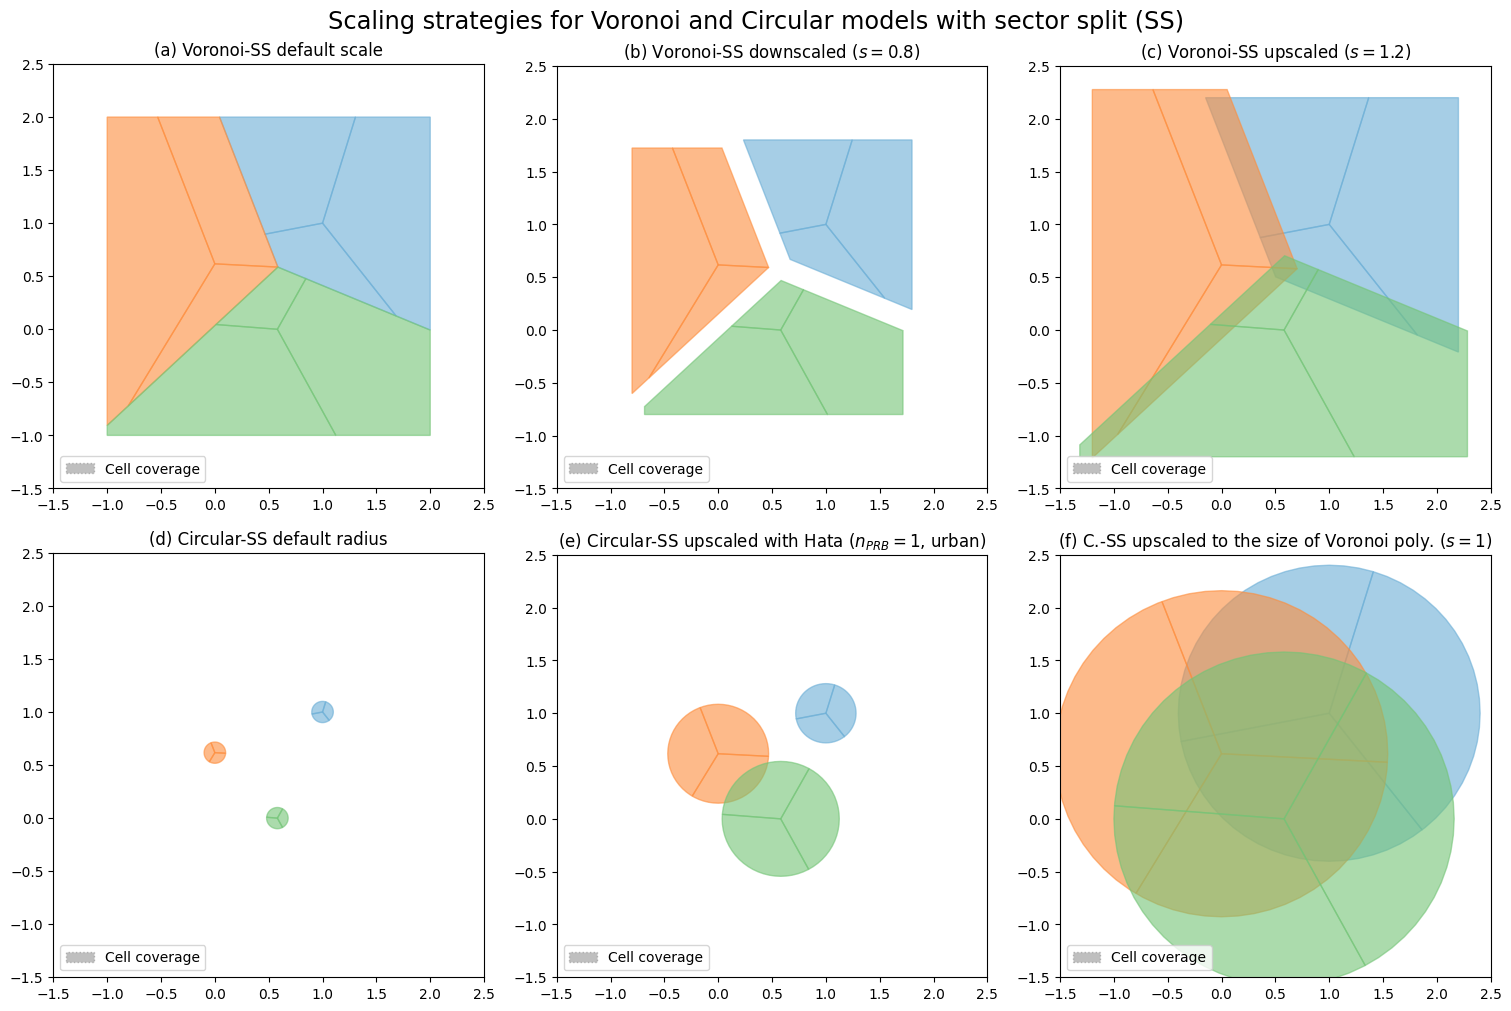

In [35]:
coverages = [voro1, voro_down, voro_up, circle_default, circle50_km, vorocircle]
titles = [
    '(a) Voronoi-SS default scale',
    '(b) Voronoi-SS downscaled ($s=0.8$)',
    '(c) Voronoi-SS upscaled ($s=1.2$)',
    '(d) Circular-SS default radius',
    '(e) Circular-SS upscaled with Hata ($n_{PRB}=1$, urban)',
    '(f) C.-SS upscaled to the size of Voronoi poly. ($s=1$)',
]

def plot_scale(coverage, topo, title, ax):
    ax.set_xlim([-1.5, 2.5])
    ax.set_ylim([-1.5, 2.5])
    handles = []

    # plot cell sector coverage
    az_color = topo.rescale_azimut(coverage.cell_shapes.azimut)
    for r, az_c in zip(coverage.cell_shapes.iterrows(), az_color):
        values = r[1]
        p = values.geometry
        bs = values.bs_id
        x, y = p.exterior.xy
        ax.fill(x, y, linestyle='solid', color=topo.site_color[bs](0.5), alpha=0.6)
    handles.append(mpatches.Patch(color='gray', label='Cell coverage', alpha=0.5, linestyle='dotted'))
    ax.legend(handles=handles, loc='lower left')
    ax.set_title(title)
    return ax


# gridspec inside gridspec
fig = plt.figure(layout='constrained', figsize=(15, 10))
subfigs = fig.subfigures(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

for i in range(2):
    for j in range(3):
        idx = 3*i + j
        ax = subfigs[i, j].subplots(1, 1)
        pc = plot_scale(coverages[idx], topo, titles[idx], ax)
#subfigs[0, 0].suptitle('Left plots', fontsize='x-large')

fig.suptitle('Scaling strategies for Voronoi and Circular models with sector split (SS)', fontsize='xx-large')
plt.savefig(f'coverage_scales.pdf')
plt.show()
